# Аналитика в Яндекс.Афише

На основе данных от Яндекс.Афиши (с июня 2017 по конец мая 2018 года) необходимо сформировать предложения по оптимизации маркетинговых затрат.

В нашем распоряжении:
- лог сервера с данными о посещениях сайта Яндекс.Афиши
- выгрузка всех заказов за этот период
- статистика рекламных расходов

**Описание данных**:

Таблица **visits** (лог сервера с информацией о посещениях сайта):
- `Uid` — уникальный идентификатор пользователя
- `Device` — категория устройства пользователя
- `Start Ts` — дата и время начала сессии
- `End Ts` — дата и время окончания сессии
- `Source Id` — идентификатор рекламного источника, из которого пришел пользователь

Таблица **orders** (информация о заказах):
- `Uid` — уникальный id пользователя, который сделал заказ
- `Buy Ts` — дата и время заказа
- `Rvenue` — выручка Яндекс.Афиши с этого заказа

Таблица **costs** (информация о затратах на маркетинг):
- `source_id` — идентификатор рекламного источника
- `dt` — дата
- `costs` — затраты на этот рекламный источник в этот день

**План работы:**  <a id="plan"></a> 
1. [Обзор данных.](#st1)
2. [Предобработка данных. Приведение типов. Обработка пропущенных значений.](#st2)
3. [Исследовательский анализ данных.](#st3)
   - [3.1. Продукт.](#st3_1)
   - [3.2. Продажи.](#st3_2)
   - [3.3. Маркетинг.](#st3_3)
4. [Общий вывод.](#st4)

### [1. Обзор данных](#plan) <a id="st1"></a> 

In [11]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

In [12]:
visits = pd.read_csv('06_visits_log.csv')
orders = pd.read_csv('06_orders_log.csv')
costs = pd.read_csv('06_costs.csv')

In [13]:
def data_info(df):
# Функция принимает на вход датафрейм df и выводит результат методов sample(5), info(), describe(), 
# а также количество полных дубликатов
    display(df.sample(5))
    display(df.info())
    display(df.describe())
    print('Дубликатов:', df.duplicated().sum())

In [14]:
# Рассмотрим таблицу информацией о посещениях:
data_info(visits)

,Device,End Ts,Source Id,Start Ts,Uid
5059,touch,2018-01-09 14:50:00,5,2018-01-09 14:46:00,6702624850732388337
355915,desktop,2018-02-09 22:36:00,3,2018-02-09 22:35:00,15559948300133637507
305035,desktop,2017-10-22 13:20:00,4,2017-10-22 13:20:00,13933924462898182978
89187,desktop,2018-02-26 13:58:00,5,2018-02-26 13:51:00,14282734599192029367
89599,touch,2017-09-19 23:39:00,4,2017-09-19 23:38:00,17415916938405449064


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


Дубликатов: 0


Проблемы:
- некорректные названия столбцов
- тип данных `Start Ts` и `End Ts` должен быть datetime, а не object

В базе данные о 359400 сессиях, пропусков и дубликатов нет.

In [15]:
# Рассмотрим таблицу информацией о заказах:
data_info(orders)

,Buy Ts,Revenue,Uid
36856,2018-02-25 12:58:00,1.59,12395127584263010924
50253,2018-05-31 17:12:00,2.32,860789994789595601
22166,2017-12-05 19:48:00,1.95,11040165179097553590
19464,2017-11-24 17:34:00,10.08,8256137149745960090
13064,2017-10-16 15:58:00,1.47,10908357416612514853


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


Дубликатов: 0


Проблемы:
- некорректные названия столбцов
- тип данных `Buy Ts` должен быть datetime, а не object
- встречаются заказы с нулевой выручкой - нужно посмотреть внимательней

Распределение выручки скошено вправо. Большое стандартное отклонение говорит о существенном разбросе значений.
Всего в базе содержится информация о 50415 заказх, пропусков и дубликатов нет.

In [16]:
# Рассмотрим таблицу информацией о затратах на маркетинг:
data_info(costs)

,source_id,dt,costs
390,2,2017-06-28,108.52
2374,10,2017-12-13,27.34
2500,10,2018-04-20,9.13
1650,5,2017-12-16,199.98
2405,10,2018-01-13,6.40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


Дубликатов: 0


Проблемы:
- тип данных `dt` должен быть datetime, а не object

Распределение затрат скошено вправо. Большое стандартное отклонение говорит о существенном разбросе значений.
Всего в базе 2542 записей с затратами, пропущенных значений и дубликатов нет.

### Обзор данных. Выводы

Данные выгружены без пропусков и дубликатов. 
Всего в нашем распоряжении данные о:
- 359400 сессиях / `visits`
- 50415 заказах / `orders`
- 2542 затратах / `costs`

В таблице `orders` встречаются записи с нулевой выручкой.

Обнаруженные проблемы:
- нужно переименовать столбцы в `visits` и `orders`
- `visits['Start Ts']` и `visits['End Ts']` нужно привести к datetime
- `orders['Buy Ts']` нужно привести к datetime
- `costs['dt']` нужно привести к datetime

### [2. Предобработка данных](#plan) <a id="st2"></a> 

In [17]:
# Скорректируем названия столбцов в `visits` и `orders`:
visits.columns = visits.columns.str.replace(' ', '_')
visits.columns = visits.columns.str.lower()

orders.columns = orders.columns.str.replace(' ', '_')
orders.columns = orders.columns.str.lower()

display(visits.sample(5))
display(orders.sample(5))

,device,end_ts,source_id,start_ts,uid
38365,desktop,2017-07-21 01:19:00,5,2017-07-21 01:08:00,3787059002742333113
128481,touch,2017-11-08 00:16:00,2,2017-11-08 00:04:00,18394113490043757560
191604,touch,2017-11-07 23:25:00,4,2017-11-07 23:20:00,203078386373707330
28635,touch,2018-03-21 18:54:00,10,2018-03-21 18:54:00,5697232637142501279
157349,desktop,2018-04-16 17:30:00,5,2018-04-16 17:20:00,10129597166023078885


,buy_ts,revenue,uid
14706,2017-10-26 14:32:00,0.30,4481174232688656942
8817,2017-09-23 22:08:00,0.30,8526122397329055468
19360,2017-11-24 16:02:00,1.47,6600396643158224277
31733,2018-01-29 21:26:00,3.67,4159403512545490308
18922,2017-11-23 02:49:00,1.47,6972599768698540579


In [18]:
def to_dttime(df, param, frmt):
# Функция заменяет тип поля df[param] на datetime по формату frmt и выводит описание поля df[param]
    try:
        df[param] = pd.to_datetime(df[param], format=frmt)
        print(param, ':')
        print(df[param].describe())
        print()
    except:
        print('Проверьте корректность данных в поле', param)   

In [19]:
# Заменим тип данных на datetime там, где это нужно:

to_dttime(visits, 'start_ts', '%Y-%m-%d %H:%M:%S')
to_dttime(visits, 'end_ts', '%Y-%m-%d %H:%M:%S')
to_dttime(orders, 'buy_ts', '%Y-%m-%d %H:%M:%S')
to_dttime(costs, 'dt', '%Y-%m-%d %H:%M:%S')

start_ts :
count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

end_ts :
count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object

buy_ts :
count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

dt :
count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object



In [20]:
display(orders[orders['buy_ts'] >= '2018-06-01'])

# В выгрузку попала одна строчка с заказом в июне 2018 - исключим её из рассмотрения, чтобы не портить статистику по месяцам:
orders = orders[orders['buy_ts'] < '2018-06-01']

,buy_ts,revenue,uid
50414,2018-06-01 00:02:00,3.42,83872787173869366


Проверим заказы на наличие выбросов.

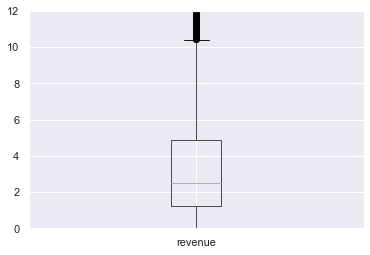

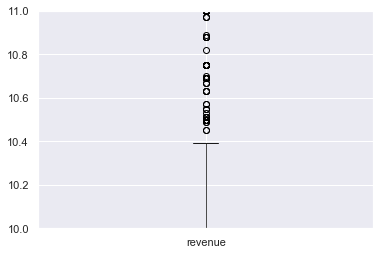

In [21]:
plt.ylim(0, 12)
orders.boxplot(column='revenue', figsize=(10,5))
plt.figure()
plt.ylim(10, 11)
orders.boxplot(column='revenue', figsize=(10,5)) # revenue < 10.5
plt.show()

In [12]:
print(len(orders[orders['revenue'] >= 10.4]))
print('Доля выбросов:', round((len(orders[orders['revenue'] >= 10.4]) / len(orders) * 100)), '%')

3990
Доля выбросов: 8 %


### Предобработка данных. Выводы

- Исправили названия столбцов в `visits` и `orders`.
- Заменили тип `visits['start_ts']`, `visits['end_ts']`, `orders['buy_ts']` и `costs['dt']` на datetime
- Исключили из рассмотрения заказ, оформленный в июне 2018
- Выявили выбросы в таблице с заказами (8% от общего числа заказов). Граница находится на значении `revenue` > 10.5.

### [3. Исследовательский анализ данных](#plan) <a id="st3"></a> 

#### [3.1. Продукт](#plan) <a id="st3_1"></a> 

In [22]:
# Добавим в таблицу visits необходимые для дальнейшего анализа поля:
visits['day'] = visits['start_ts'].dt.day
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
visits['date'] = visits['start_ts'].dt.date

visits.sample(5)

,device,end_ts,source_id,start_ts,uid,day,week,month,year,date
10421,touch,2018-03-07 20:48:00,4,2018-03-07 20:47:00,2874812633794757289,7,10,3,2018,2018-03-07
47539,touch,2018-02-03 19:41:00,3,2018-02-03 19:26:00,14147291608625380951,3,5,2,2018,2018-02-03
65974,desktop,2018-02-26 10:27:00,2,2018-02-26 10:18:00,13216107653026783144,26,9,2,2018,2018-02-26
14330,desktop,2018-03-20 15:55:00,2,2018-03-20 15:01:00,9236921623810515520,20,12,3,2018,2018-03-20
144250,desktop,2018-03-04 13:56:00,3,2018-03-04 13:49:00,11917513876882014813,4,9,3,2018,2018-03-04


#### Количество уникальных пользователей и количество сессий за период

In [23]:
"""
Функция подсчитывает количество уникальных пользователей и количество сессий за период, выводит графики;
строит графики распределений, а также выводит описание .describe() группировки.
Входные параметры:
    `df` - датафрейм с информацией о посещениях сервиса
    `period` - список полей для группировки по периоду
    `period_name` - название периода в винительном падеже для заголовков.
"""
def nusers_period(df, period, period_name):  
    nusers = (df.groupby(period)
                  .agg(
                      user_count = ('uid','nunique'),
                      session_count = ('uid','count'))
             )
    nusers['sessions_per_user'] = nusers['session_count'] /  nusers['user_count']
    display(nusers.sample(5))
    nusers.sort_values(by=period, inplace=True)
    nusers[['user_count', 'session_count']].plot(figsize=(15,5), grid=True, style='o', title='Количество пользователей/сессий в '+ period_name)
    plt.ylabel('количество пользователей/сессий')
    plt.show()
    
    plt.figure(figsize=(10,5))
    sns.distplot(nusers['user_count'], bins=20, label='пользователи')
    sns.distplot(nusers['session_count'], bins=20, label='сессии')
    plt.title('Распределение количества пользователей/сессий в ' + period_name)
    plt.legend()
    plt.show() 
    
    display(nusers.describe())

,user_count,session_count,sessions_per_user
date,,,
2017-06-13,502,536,1.067729
2017-07-07,542,573,1.057196
2018-03-13,1124,1244,1.106762
2017-11-10,1197,1299,1.085213
2018-01-11,1238,1325,1.070275


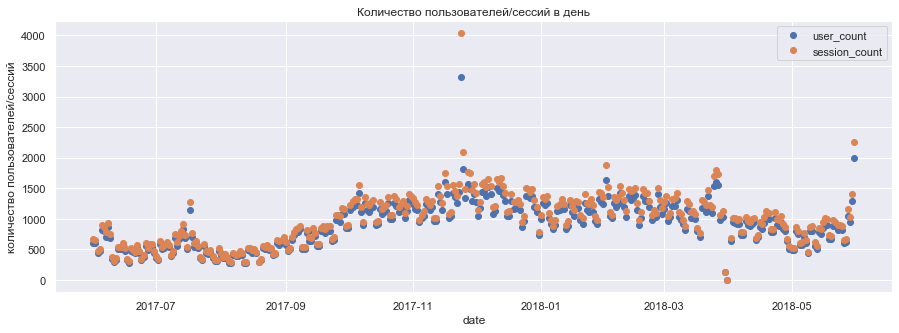

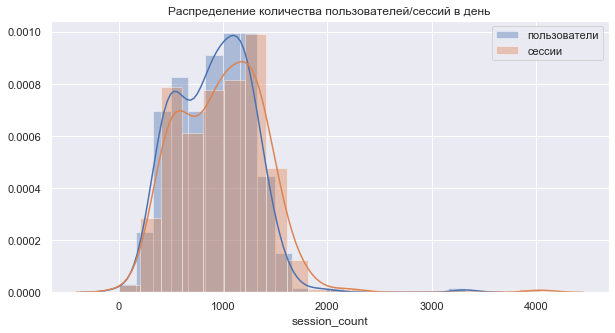

,user_count,session_count,sessions_per_user
count,364.000000,364.000000,364.000000
mean,907.991758,987.362637,1.082170
std,370.513838,418.994796,0.020876
min,1.000000,1.000000,1.000000
25%,594.000000,635.500000,1.070321
50%,921.000000,1003.000000,1.082488
75%,1173.000000,1280.000000,1.093876
max,3319.000000,4042.000000,1.217837


In [24]:
# Посмотрим, сколько людей пользуются сервисом в день:
nusers_period(visits, ['date'], 'день')

- Рспределения количества пользователей и сессий в день стремятся к нормальному.
- В среднем в день сервисом пользуются порядка 900 человек, сессий случается чуть больше - 990. Можно сказать, что человек пользуется сервисом не больше одного раза в день.
- В конце декабря наблюдается всплеск - вероятно, пользователи интересовались новогодней афишей.

,,user_count,session_count,sessions_per_user
year,week,,,
2017,35,3694,4296,1.162967
2018,1,6918,8057,1.164643
2017,50,8214,10120,1.232043
2018,15,5494,6382,1.161631
2017,33,2746,3128,1.139111


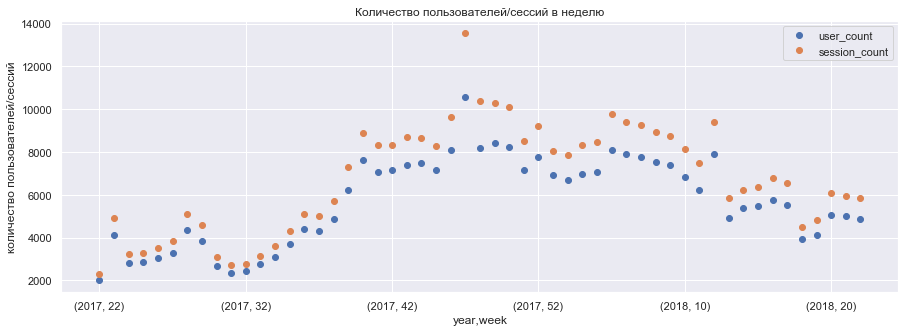

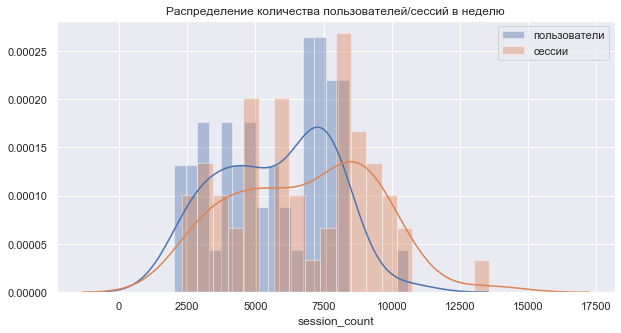

,user_count,session_count,sessions_per_user
count,53.000000,53.000000,53.000000
mean,5716.245283,6781.132075,1.179025
std,2049.898027,2549.571427,0.029427
min,2021.000000,2309.000000,1.137248
25%,4128.000000,4803.000000,1.159576
50%,5740.000000,6768.000000,1.175714
75%,7401.000000,8712.000000,1.190836
max,10586.000000,13572.000000,1.282071


In [25]:
# Посмотрим, сколько людей пользуются сервисом в неделю:
nusers_period(visits, ['year', 'week'], 'неделю')

- Тенденции в целом сохраняются: среднее количество сессий на пользователя - 1.17, т.е., за редким исключением, человек заходит на сервис не чаще одного раза в неделю.
- Среднее количество пользователей в неделю - 5715, среднее количество сессий - 6780

user_count  session_count  sessions_per_user
year month                                              
2017 6           13259          16505           1.244815
     9           18975          23907           1.259921
2018 4           21008          26515           1.262138
     5           20701          26635           1.286653
2017 8           11631          14355           1.234202

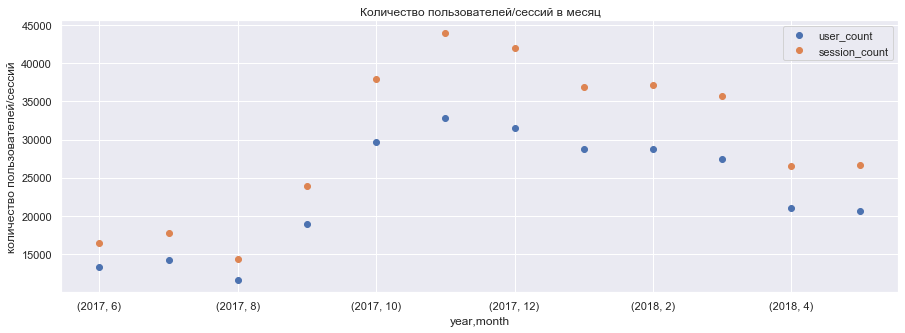

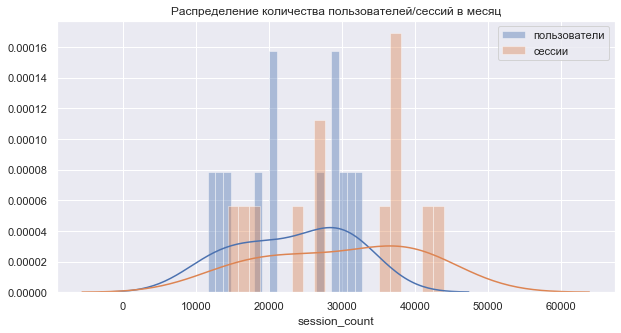

,user_count,session_count,sessions_per_user
count,12.000000,12.000000,12.000000
mean,23228.416667,29950.000000,1.280889
std,7546.380462,10307.835846,0.032217
min,11631.000000,14355.000000,1.234202
25%,17777.000000,22387.250000,1.259190
50%,24240.500000,31157.000000,1.281448
75%,28984.750000,37362.250000,1.294672
max,32797.000000,43969.000000,1.340641


In [26]:
# Посмотрим, сколько людей пользуются сервисом в месяц:
nusers_period(visits, ['year', 'month'], 'месяц')

- Картина та же: среднее количество сессий на пользователя - 1.28 в месяц, т.е. из четырёх человек только один пользуется сервисом два раза в месяц, остальные - единожды.
- Среднее количество пользователей в месяц - 23230, количество сессий - 29959.

#### Средняя продолжительность сессии

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64


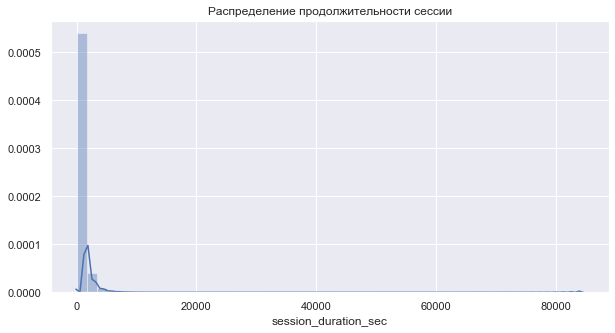

In [27]:
# Рассчитаем среднюю продолжительность сессии (ASL - average session length):
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

print(visits['session_duration_sec'].describe())

# Посмотрим на распределение продолжительности сессии:
plt.figure(figsize=(10,5))
sns.distplot(visits['session_duration_sec'], bins=50)
plt.title('Распределение продолжительности сессии')
plt.show() 

Распределение далеко от нормального, поэтому для определения средней продолжительности сессии найдём моду - значение в выборке, которое встречается чаще всего:

In [28]:
print('Средняя продолжительность сессии:', visits['session_duration_sec'].mode()[0], 'секунд')

Средняя продолжительность сессии: 60 секунд


In [29]:
# Посмотрим есть ли связь с платформой пользователя:

print('touch - мода:',visits[visits['device']=='touch']['session_duration_sec'].mode()[0])
print('desktop - мода:',visits[visits['device']=='desktop']['session_duration_sec'].mode()[0])
print('touch - медиана:',visits[visits['device']=='touch']['session_duration_sec'].median())
print('desktop - медиана:',visits[visits['device']=='desktop']['session_duration_sec'].median())

touch - мода: 60
desktop - мода: 60
touch - медиана: 180.0
desktop - медиана: 360.0


- Если смотреть на моду, то разницы нет - чаще всего сессия пользователя длится 60 секунд вне зависимости от платформы.
- Медиана демонстрирует существенную разницу - если уж сессия получилась "нестандартная", на компьютере она в среднем длится дольше.

#### Частота возвращений пользователя (sticky factor)

In [30]:
# Рассчитаем среднюю частоту возвращения пользователей (sticky factor):

mau_total = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()
dau_total = visits.groupby('date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()

sticky_wau = dau_total / wau_total
sticky_mau = dau_total / mau_total

print('DAU/WAU (week sticky factor): {:.2%}'.format(sticky_wau[0]))
print('DAU/MAU (month sticky factor): {:.2%}'.format(sticky_mau[0]))

DAU/WAU (week sticky factor): 15.88%
DAU/MAU (month sticky factor): 3.91%


Sticky factor - или вероятность того, что новый привлеченный пользователь будет часто появляться - довольно мала. С другой стороны, для афиши данная метрика не слишком применима - ведь нам не так важно, чтобы пользователь постоянно заходил на сервис, важнее - чтобы он в принципе не пропадал.

**Коэффициент удержания пользователей (Retention Rate)**

In [31]:
# Добавим в таблицу с сессиями информацию о первом визите пользователя:
first_visit_date = visits.groupby(['uid'])['date'].min()
first_visit_date.name = 'first_visit_date'
user_visits = visits.join(first_visit_date, on='uid')
display(user_visits.sample(5))

,device,end_ts,source_id,start_ts,uid,day,week,month,year,date,session_duration_sec,first_visit_date
188320,touch,2017-12-24 09:35:00,5,2017-12-24 09:34:00,4179297715951461562,24,51,12,2017,2017-12-24,60,2017-12-24
59066,desktop,2018-03-27 12:12:00,5,2018-03-27 12:01:00,3998119830739751340,27,13,3,2018,2018-03-27,660,2018-03-27
141793,desktop,2018-02-15 13:27:00,4,2018-02-15 13:21:00,12201709297213112441,15,7,2,2018,2018-02-15,360,2018-02-15
323544,desktop,2017-12-06 06:29:00,4,2017-12-06 06:19:00,12683370860610769853,6,49,12,2017,2017-12-06,600,2017-12-06
308949,desktop,2018-03-15 12:28:00,4,2018-03-15 12:26:00,3919261807971903228,15,11,3,2018,2018-03-15,120,2018-03-15


In [32]:
# Добавим месяц сессии и месяц первого визита:
user_visits['visit_month'] = user_visits['date'].values.astype('datetime64[M]')
user_visits['first_visit_month'] = user_visits['first_visit_date'].values.astype('datetime64[M]')

# Добавим lifetime пользователя в рамках когорты:
user_visits['cohort_lifetime'] = user_visits['visit_month'] - user_visits['first_visit_month']
user_visits['cohort_lifetime'] = user_visits['cohort_lifetime'] / np.timedelta64(1,'M')
user_visits['cohort_lifetime'] = round(user_visits['cohort_lifetime']).astype('int')

# Посчитаем для каждой когорты количество активных пользователей на каждый месяц:
cohorts = user_visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

# Найдём исходное количество пользователей в когорте:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

# Объединим данные по когортам с исходным количеством пользователей в когорте:
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')

# Рассчитаем Retention Rate:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

display(cohorts.head(5))

,first_visit_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


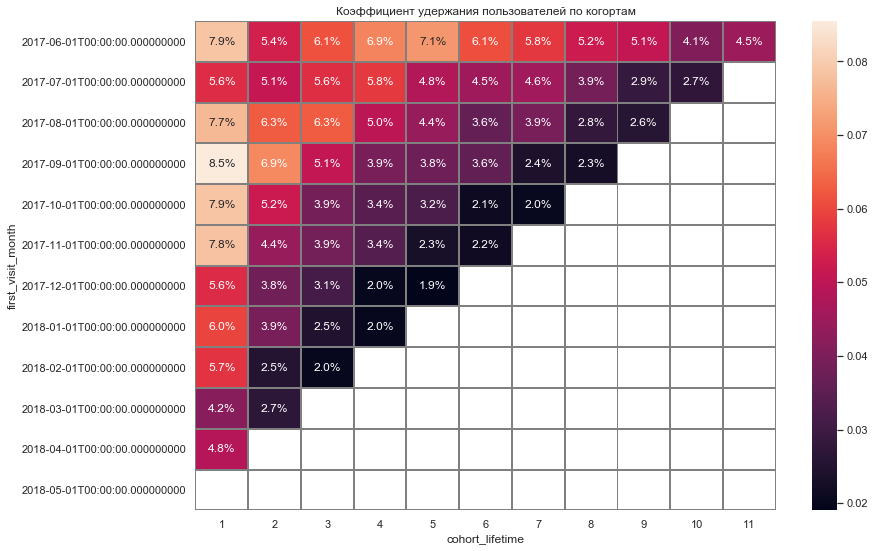

In [33]:
retention_pivot = cohorts.pivot_table(index='first_visit_month', columns='cohort_lifetime', values='retention', aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Коэффициент удержания пользователей по когортам')

#display(retention_pivot.loc[:,1:11])
sns.heatmap(retention_pivot.loc[:,1:11], annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Очевидно, что показатели удержания пользователей крайне низкие и с течением времени они падают (как внутри когорты, так и от когорты к когорте).

#### [3.2. Продажи](#plan) <a id="st3_2"></a> 

In [34]:
# Добавим в таблицу с заказами `orders` информацию о первом заказе пользователя.
# Составим справочник с датой первого заказа:
first_order_date = orders.groupby('uid')['buy_ts'].min() 
first_order_date.name = 'first_order_date'

# Объединим таблицы:
orders = orders.join(first_order_date, on='uid')
display(orders.head())

,buy_ts,revenue,uid,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


Посмотрим, какое время в среднем требуется пользователю для совершения первой покупки.

Доля пользователей, совершивших хотя бы одну покупку: 16.01%


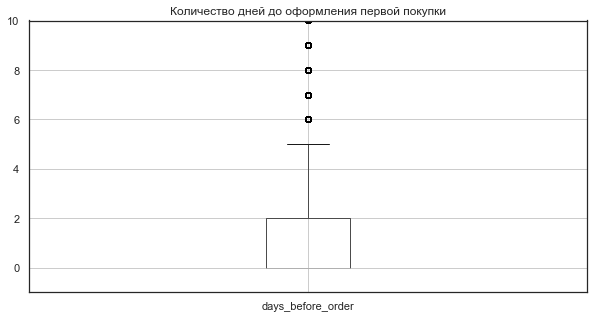

count    36522.000000
mean        16.730327
std         46.959650
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: days_before_order, dtype: float64


In [35]:
# Построим таблицу с первой сессией каждого пользователя:
first_visits = visits.groupby('uid').agg(first_ts=('start_ts', 'min'))
first_visits = pd.DataFrame(first_visits)

# Добавим в таблицу `first_visits` информацию о первой покупке для каждого пользователя:
first_visits = first_visits.join(first_order_date, on='uid').reset_index()

# Рассчитаем количество дней от первой сессии до первой покупки:
first_visits['days_before_order'] = (first_visits['first_order_date'] - first_visits['first_ts']).dt.days

#display(first_visits.sample(5))
print('Доля пользователей, совершивших хотя бы одну покупку: {:.2%}'.format(first_visits[~first_visits['days_before_order'].isna()]['uid'].count() / first_visits.shape[0]))

plt.figure(figsize=(10,5))
plt.title('Количество дней до оформления первой покупки')
#first_visits['days_before_order'].hist(bins=30)
plt.ylim(-1, 10)
first_visits.boxplot(column='days_before_order')
plt.show()

print(first_visits['days_before_order'].describe())

Большинство пользователей совершают покупку в день своей первой сессии.

Проведём когортный анализ и посмотрим, как по месяцам изменяется количество пользователей, совершивших покупку впервые.

In [36]:
# Добавим в таблицу `orders` необходимые для дальнейшего анализа поля -
# месяц заказа `order_month` и месяц первого заказа `first_order_month`:

orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

display(orders.sample(5))

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
48848,2018-05-24 23:30:00,1.83,7171152781040191377,2017-07-10 11:18:00,2017-07-01,2018-05-01
26232,2017-12-26 16:59:00,1.59,9208938855179340669,2017-12-26 12:23:00,2017-12-01,2017-12-01
2663,2017-07-05 23:55:00,2.44,15887689290160602645,2017-07-05 23:55:00,2017-07-01,2017-07-01
2162,2017-06-28 15:33:00,0.61,2266148757561034462,2017-06-28 15:27:00,2017-06-01,2017-06-01
40168,2018-03-16 16:17:00,0.61,15825575654287616781,2018-03-16 16:17:00,2018-03-01,2018-03-01


,orders_count,users_nunique,revenue,orders_per_user
first_order_month,,,,
2017-06-01,4322,2023,24031.69,2.136431
2017-07-01,2797,1923,16127.92,1.454498
2017-08-01,2133,1370,11606.26,1.556934
2017-09-01,3730,2581,34676.32,1.445176
2017-10-01,5573,4340,27603.45,1.284101
2017-11-01,5361,4081,26098.99,1.313649
2017-12-01,5483,4383,33485.74,1.250970
2018-01-01,4069,3373,16663.13,1.206345
2018-02-01,4143,3651,16750.50,1.134758


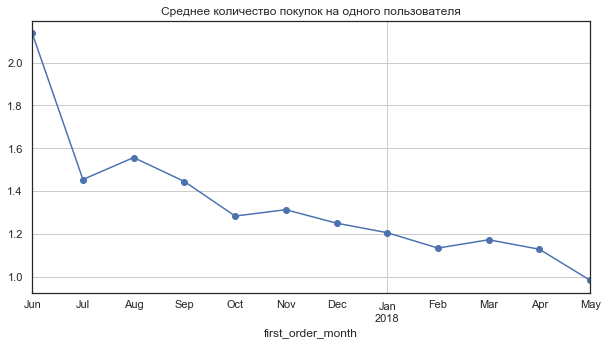

In [37]:
# Сгруппируем данные по столбцу `first_order_month` и оценим показатели каждой когорты:
cohorts = orders.groupby('first_order_month').agg(orders_count=('buy_ts','nunique'), 
                                                  users_nunique=('uid','nunique'), 
                                                  revenue=('revenue','sum'))

# Добавим в таблицу среднее количество покупок на одного пользователя когорты:
cohorts['orders_per_user'] = cohorts['orders_count'] / cohorts['users_nunique']
display(cohorts)

cohorts['orders_per_user'].plot(figsize=(10,5), grid=True, style='o-', title='Среднее количество покупок на одного пользователя')
plt.show()

#cohorts['users_nunique'].plot(figsize=(10,5), grid=True, style='o-', title='Количество уникальных пользователей по месяцам')
#plt.show()

- Среднее количество покупок на одного пользователя снижается от когорте к когорте - оно и понятно, ведь снижается их "время жизни" в сервисе.
- Однако, даже по прошествии года с момента первой покупки, среднее количество покупок еле переваливает за 2.

Отследим, как изменяется среднее количество покупок пользователя внутри одной когорты.

In [38]:
cohorts_month = orders.groupby(['first_order_month', 'order_month']).agg(orders_count=('buy_ts','nunique'), users_nunique=('uid','nunique'), revenue=('revenue','sum'))

# Добавим в таблицу среднее количество покупок на одного пользователя:
cohorts_month['orders_per_user'] = cohorts_month['orders_count'] / cohorts_month['users_nunique']
display(cohorts_month)

orders_count  users_nunique   revenue  \
first_order_month order_month                                          
2017-06-01        2017-06-01           2245           2023   9557.49   
                  2017-07-01            176             61    981.82   
                  2017-08-01            174             50    885.34   
                  2017-09-01            223             54   1931.30   
                  2017-10-01            292             88   2068.58   
...                                     ...            ...       ...   
2018-03-01        2018-04-01            178             90   1063.05   
                  2018-05-01            176             58   1114.87   
2018-04-01        2018-04-01           2375           2276  10600.69   
                  2018-05-01            195             69   1209.92   
2018-05-01        2018-05-01           2941           2988  13925.76   

                               orders_per_user  
first_order_month order_month                   
2017-06-01        2017-06-01          1.109738  
                  2017-07-01          2.885246  
                  2017-08-01          3.480000  
                  2017-09-01          4.129630  
                  2017-10-01          3.318182  
...                                        ...  
2018-03-01        2018-04-01          1.977778  
                  2018-05-01          3.034483  
2018-04-01        2018-04-01          1.043497  
                  2018-05-01          2.826087  
2018-05-01        2018-05-01          0.984270  

[78 rows x 4 columns]

In [39]:
print('Среднее количество покупок на пользователя')
cohorts_month.pivot_table(index='first_order_month',
                          columns='order_month',
                          values='orders_per_user',
                          aggfunc='mean'
                         ).fillna('')

Среднее количество покупок на пользователя


order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_order_month,,,,,,,,,,,,
2017-06-01,1.10974,2.88525,3.48,4.12963,3.31818,3.23881,4.43548,3.70213,3.65517,3.37778,2.13333,1.622642
2017-07-01,,1.07956,1.92308,2.10526,1.60938,1.46939,2.15789,1.66667,1.25641,1.38095,1.09091,2.038462
2017-08-01,,,1.08102,1.84483,1.88679,1.81818,2.1,1.9375,1.63333,1.77273,2.42105,1.483871
2017-09-01,,,,1.07943,1.68462,1.6,2.21622,1.28846,1.70312,1.63636,1.51351,1.418605
2017-10-01,,,,,1.04447,1.51942,1.31707,1.32609,1.3871,1.43056,1.53571,1.865672
2017-11-01,,,,,,1.04974,1.75676,1.5,1.98113,1.67901,1.22917,1.645161
2017-12-01,,,,,,,1.05909,1.84247,1.96117,1.84536,1.72,1.666667
2018-01-01,,,,,,,,1.05129,1.94737,1.91566,1.48837,1.733333
2018-02-01,,,,,,,,,1.03232,1.87288,1.43103,1.794872


Так же для полноты картины выведем количество активных покупателей когорты помесячно.

In [40]:
print('Количество покупателей внутри когорты')
cohorts_month.pivot_table(index='first_order_month',
                          columns='order_month',
                          values='users_nunique',
                          aggfunc='mean'
                         ).fillna('')

Количество покупателей внутри когорты


order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_order_month,,,,,,,,,,,,
2017-06-01,2023,61,50,54,88,67,62,47,58,45,45,53.0
2017-07-01,,1923,52,57,64,49,38,36,39,42,22,26.0
2017-08-01,,,1370,58,53,44,40,32,30,44,19,31.0
2017-09-01,,,,2581,130,100,74,52,64,66,37,43.0
2017-10-01,,,,,4340,206,123,92,93,72,56,67.0
2017-11-01,,,,,,4081,222,120,106,81,48,62.0
2017-12-01,,,,,,,4383,146,103,97,50,63.0
2018-01-01,,,,,,,,3373,114,83,43,45.0
2018-02-01,,,,,,,,,3651,118,58,39.0


- Мы видим резкий спад после первой покупки - большинство пользователей оформляют заказ единожды.
- Оставшиеся в сервисе покупатели совершают максимум 1.5-2 покупки в месяц.
- При этом лояльные пользователи первой когорты (те, кто в итоге совершил более одной покупки) покупали почти в 2 раза больше пользователей из других когорт.
- После первого месяца количество покупателей в когорте резко снижается.
- В осенне-зимний период (с октября по март) количество новых покупателей больше, чем в другое время года.
- При этом в ноябре, декабре и январе количество покупателей в целом уменьшается во всех когортах.

**Рассчитаем средний чек покупателей в месяц.**

In [41]:
# Добавим в нашу группировку средний чек покупателя:
cohorts_month['revenue_per_user'] = cohorts_month['revenue'] / cohorts_month['users_nunique']

display(cohorts_month)

#Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки:
cohorts_month.pivot_table(index='first_order_month',
                          columns='order_month',
                          values='revenue_per_user',
                          aggfunc='mean'
                         ).fillna('')

orders_count  users_nunique   revenue  \
first_order_month order_month                                          
2017-06-01        2017-06-01           2245           2023   9557.49   
                  2017-07-01            176             61    981.82   
                  2017-08-01            174             50    885.34   
                  2017-09-01            223             54   1931.30   
                  2017-10-01            292             88   2068.58   
...                                     ...            ...       ...   
2018-03-01        2018-04-01            178             90   1063.05   
                  2018-05-01            176             58   1114.87   
2018-04-01        2018-04-01           2375           2276  10600.69   
                  2018-05-01            195             69   1209.92   
2018-05-01        2018-05-01           2941           2988  13925.76   

                               orders_per_user  revenue_per_user  
first_order_month order_month                                     
2017-06-01        2017-06-01          1.109738          4.724414  
                  2017-07-01          2.885246         16.095410  
                  2017-08-01          3.480000         17.706800  
                  2017-09-01          4.129630         35.764815  
                  2017-10-01          3.318182         23.506591  
...                                        ...               ...  
2018-03-01        2018-04-01          1.977778         11.811667  
                  2018-05-01          3.034483         19.221897  
2018-04-01        2018-04-01          1.043497          4.657597  
                  2018-05-01          2.826087         17.535072  
2018-05-01        2018-05-01          0.984270          4.660562  

[78 rows x 5 columns]

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_order_month,,,,,,,,,,,,
2017-06-01,4.72441,16.0954,17.7068,35.7648,23.5066,22.2078,31.0119,25.0332,19.2957,27.2336,25.6813,9.804151
2017-07-01,,6.01022,12.3963,21.036,10.7861,6.93816,7.89684,6.42111,6.99282,7.38214,12.8618,11.513846
2017-08-01,,,5.27652,11.1488,11.8513,12.183,16.9212,12.1391,9.62033,12.6105,21.07,8.307419
2017-09-01,,,,5.64453,22.1884,13.4452,138.669,19.8815,26.095,27.4371,16.9614,11.044651
2017-10-01,,,,,5.00373,11.2874,6.75325,7.41315,7.0728,7.25514,6.57321,7.479701
2017-11-01,,,,,,5.15468,7.33905,6.78658,12.5107,7.45728,4.58083,7.564839
2017-12-01,,,,,,,4.73819,7.81658,39.366,48.1351,27.4314,23.518413
2018-01-01,,,,,,,,4.13564,8.72123,12.3655,11.1998,4.699556
2018-02-01,,,,,,,,,4.15699,8.61,4.94241,6.941026


- Средний чек первой покупки в каждой когорте меньше следующего.
- Средний чек июньской когорты почти ежемесячно (кроме декабря, апреля и мая) больше среднего чека других когорт. Возможно, данные пользователи попали в какую-то программу лояльности/акцию/рассылку, которая повлияла на последующие покупки.
- В декабре выделяется средний чек сентябрьской когорты - 138.7 на покупателя. В целом, в декабре средний чек почти всех когорт выше предыдущего - высокий предновогодний сезон в самом разгаре.
- В декабрьской когорте, начиная с февраля, наблюдаются высокие значения среднего чека - возможно, данные пользователи стали участниками удачной маркетинговой кампании.

**LTV**

Рассчитаем итоговую сумму денег, которую пользователь приносит со всех своих покупок.

In [49]:
# Месяц первой покупки каждого пользователя:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

# Посчитаем количество новых покупателей `n_buyers` за каждый месяц:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
#display(cohort_sizes.head())

cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#display(cohorts.head())

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']

#display(report.head())

output = report.pivot_table(index='first_order_month', 
                            columns='age', 
                            values='ltv', 
                            aggfunc='mean')

print('Средняя сумма денег, которую приносит пользователь с течением времени (накопительная)')
display(output.cumsum(axis=1).round(2).fillna(''))

Средняя сумма денег, которую приносит пользователь с течением времени (накопительная)


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


,first_order_month,ltv
0,2017-06-01,11.879234
1,2017-07-01,8.386854
2,2017-08-01,8.471723
3,2017-09-01,13.435227
4,2017-10-01,6.360242
5,2017-11-01,6.395244
6,2017-12-01,7.639913
7,2018-01-01,4.940151
8,2018-02-01,4.587921
9,2018-03-01,5.455253


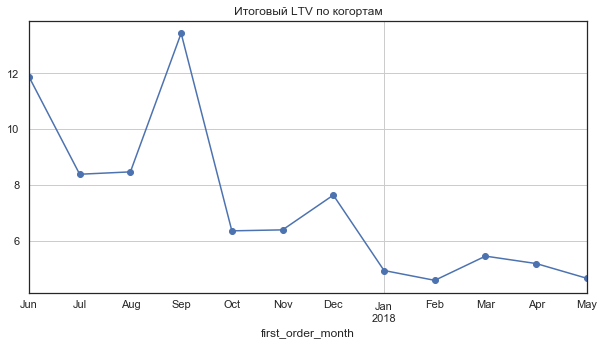

In [44]:
# Итоговый LTV по когортам:
report.groupby('first_order_month')['ltv'].sum().plot(figsize=(10,5), grid=True, style='o-', title='Итоговый LTV по когортам')
display(report.groupby('first_order_month')['ltv'].sum().reset_index())

Такой подсчёт не слишком информативен, т.к. не учитывает продолжительность жизни когорт.
Подсчитаем и сравним средние показатели шести первых когорт вплоть до их седьмого месяца жизни (0-6).

,first_order_month,ltv
0,2017-06-01,9.310524
1,2017-07-01,7.780983
2,2017-08-01,7.586526
3,2017-09-01,13.008071
4,2017-10-01,6.244772
5,2017-11-01,6.395244


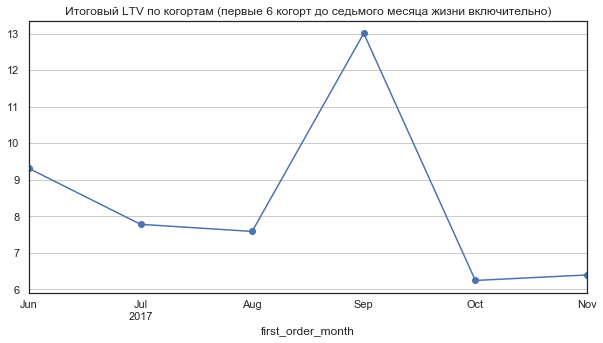

In [45]:
display(report.query('(first_order_month < "2017-12-01") & (age < 7)').groupby('first_order_month')['ltv'].sum().reset_index())

report.query('(first_order_month < "2017-12-01") & (age < 7)').groupby('first_order_month')['ltv'].sum().plot(figsize=(10,5), grid=True, style='o-', title='Итоговый LTV по когортам (первые 6 когорт до седьмого месяца жизни включительно)')
plt.show()

- Больше всего прибыли в среднем принесли пользователи сентябрьской когорты (за счёт крупной покупки в декабре).
- Не принимая в расчёт сентябрьскую когорту, в целом прослеживается снижение прибыли на пользователя от когорте к когорте.

Рассчитаем **САС** (стоимость привлечения клиента) каждой когорты.

In [50]:
# Добавим в таблицу `costs` поле с месяцем расхода:
costs['cost_month'] = costs['dt'].astype('datetime64[M]')

# Посчитаем расходы за месяц:
monthly_costs = costs.groupby('cost_month')['costs'].sum()
monthly_costs.head()

cost_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
Name: costs, dtype: float64

In [51]:
# Добавим данные о расходах в отчёт и посчитаем CAC:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='cost_month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,18015.0,8.905091


Рассчитаем **ROMI** (возврат на инвестиции) по каждой когорте.

In [52]:
# Поделим LTV на CAC:
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

print('Накопительный ROMI:')
output.cumsum(axis=1).round(2).fillna('')

Накопительный ROMI:


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


- Первая (июньская) когорта окупилась на 7-й месяц жизни, сентябрьская когорта - на 3-й месяц жизни (хорошо, что есть Новый Год), остальные окупиться не успели.

#### [3.3. Маркетинг](#plan) <a id="st3_3"></a> 

Оценим финансовые результаты работы сервиса за рассматриваемый период.

,month,revunue,costs,total
0,2017-06-01,9557.49,18015.00,-8457.51
1,2017-07-01,12539.47,18240.59,-5701.12
2,2017-08-01,8758.78,14790.54,-6031.76
3,2017-09-01,18345.51,24368.91,-6023.40
4,2017-10-01,27987.70,36322.88,-8335.18
5,2017-11-01,27069.93,37907.88,-10837.95
6,2017-12-01,36388.60,38315.35,-1926.75
7,2018-01-01,19417.13,33518.52,-14101.39
8,2018-02-01,25560.54,32723.03,-7162.49
9,2018-03-01,28834.59,30415.27,-1580.68


Суммарная выручка: 252053.78
Суммарная выручка: 252053.78
Суммарные затраты: 329131.62
Суммарные затраты: 329131.62
Суммарный результат: -77077.84


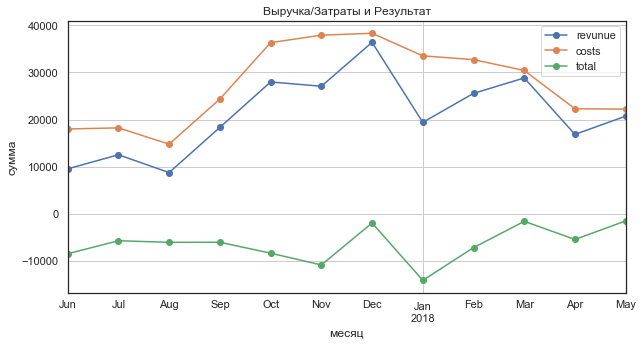

In [53]:
# Сгруппируем затраты и заказы по месяцу:
gross_profit_per_month = orders.groupby('order_month').agg(revunue=('revenue','sum')).reset_index()
costs_per_month = costs.groupby('cost_month').agg(costs=('costs','sum')).reset_index()

# Объединим ежемесячные затраты с выручкой и посчитаем результат:
#totals_per_month = gross_profit_per_month.set_index('order_month').join(costs_per_month.set_index('cost_month'))
totals_per_month = gross_profit_per_month.merge(costs_per_month, how='outer',  left_on='order_month', right_on='cost_month')
totals_per_month['total'] = totals_per_month['revunue'] - totals_per_month['costs']
totals_per_month.drop(['cost_month'], axis='columns', inplace=True)
totals_per_month = totals_per_month.rename(columns={'order_month': 'month'})

display(totals_per_month)
print('Суммарная выручка:', round(totals_per_month['revunue'].sum(), 2))
print('Суммарная выручка:', round(gross_profit_per_month['revunue'].sum(), 2))
print('Суммарные затраты:', round(totals_per_month['costs'].sum(), 2))
print('Суммарные затраты:', round(costs_per_month['costs'].sum(), 2))
print('Суммарный результат:', round(totals_per_month['revunue'].sum() - totals_per_month['costs'].sum(), 2))

totals_per_month = totals_per_month.set_index('month')
totals_per_month.plot(figsize=(10,5), grid=True, style='o-', title='Выручка/Затраты и Результат')
plt.xlabel('месяц')
plt.ylabel('сумма')
plt.show()

- За рассматриваемый период сервис сработал с убытком в -77077.84
- Самые хорошие результаты с точки зрения разницы прибыли и убытков наблюдаются в декабре и марте.

source_id
3     141321.63
4      61073.60
5      51757.10
2      42806.04
1      20833.27
10      5822.49
9       5517.49
Name: costs, dtype: float64

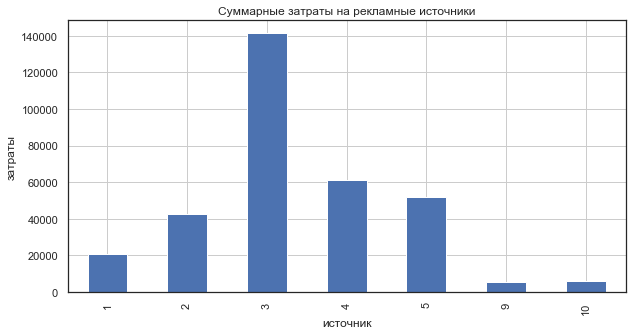

In [54]:
# Рассмотрим суммарные затраты на рекламные источники:
source_costs = costs.groupby('source_id')['costs'].sum()
display(source_costs.sort_values(ascending=False))

source_costs.plot(figsize=(10,5), grid=True, kind='bar', title='Суммарные затраты на рекламные источники')
plt.xlabel('источник')
plt.ylabel('затраты')
plt.show()

- Больше всего денег было потрачено на 3-й рекламный источник, почти в 2 раза меньше - на 4-й, и в 3 раза меньше - на 5-й.
- На 6-й, 7-й и 8-й рекламные источники деньги в рассматриваемый период не тратились.

Подсчитаем стоимость привлечения покупателя по каждому источнику.

In [55]:
# Составим справочник с источниками, через которые пользователи впервые попали на площадку сервиса:
source_per_user = visits.groupby(['uid','source_id']).agg({'start_ts':'min'}).reset_index()
source_per_user = source_per_user.sort_values(['uid','start_ts'], ascending=[True,True]).drop_duplicates('uid')
source_per_user.drop(['start_ts'], axis='columns', inplace=True)

display(source_per_user.head(5))

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


In [56]:
# Добавим в таблицу с заказами информацию о рекламном источнике, через который пользователь впервые попал на сервис:
orders = orders.merge(source_per_user, on='uid', how='left')
display(orders.head())

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,3


,revenue,nusers,costs,costs_per_user,revenue_per_user
source_id,,,,,
1,31090.55,2899,20833.27,7.186364,10.724577
2,46923.61,3506,42806.04,12.209367,13.383802
3,54511.24,10473,141321.63,13.493901,5.204931
4,56693.41,10295,61073.60,5.932356,5.506888
5,52624.02,6931,51757.10,7.467479,7.592558
7,1.22,1,NaN,NaN,1.220000
9,5759.40,1088,5517.49,5.071222,5.293566
10,4450.33,1329,5822.49,4.381106,3.348631


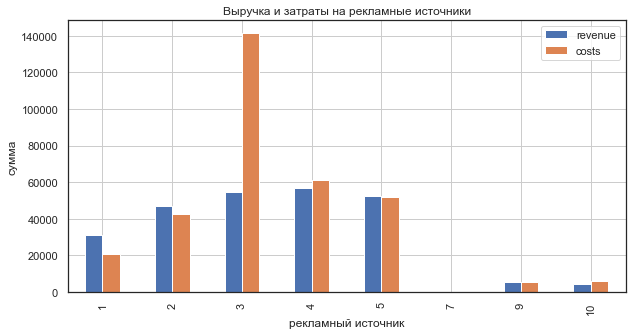

In [57]:
# Подсчитаем количество покупателей из каждого источника, а также суммарную выручку по источнику:
source_result = orders.groupby('source_id').agg({'revenue':'sum','uid':'nunique'}).reset_index()
source_result.columns = ('source_id','revenue','nusers')

# Добавим затраты:
source_result = source_result.merge(source_costs, on='source_id', how='outer')

# Рассчитаем среднюю стоимость привлечения пользователя по источнику:
source_result['costs_per_user'] = source_result['costs'] / source_result['nusers']

# Рассчитаем среднюю выручку с каждого пользователя по источнику:
source_result['revenue_per_user'] = source_result['revenue'] / source_result['nusers']

source_result = source_result.set_index('source_id')
display(source_result)

source_result[['revenue','costs']].plot(figsize=(10,5), grid=True, kind='bar', title='Выручка и затраты на рекламные источники')
plt.xlabel('рекламный источник')
plt.ylabel('сумма')
plt.show()

- Связь между затратами и выручкой по источнику не наблюдается.
- Больше всего покупателей пришло из 3-го, 4-го и 5-го рекламного источника.

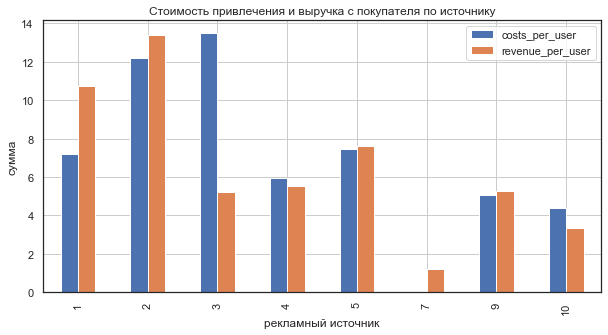

In [58]:
# Посмотрим график средней стоимости привлечения и средней выручки с покупателя по источнику:
source_result[['costs_per_user', 'revenue_per_user']].plot(figsize=(10,5), grid=True, kind='bar', title='Стоимость привлечения и выручка с покупателя по источнику')
plt.xlabel('рекламный источник')
plt.ylabel('сумма')
plt.show()

- Наибольшей отдачей отличаются 1-й и 2-й рекламные источники. 5-й и 9-й тоже в плюсе, но небольшом.
- Затраты на 3-й источник явно не оправдали себя.

Посчитаем **ROI** (окупаемость расходов) по рекламным источникам.

In [59]:
source_result['roi'] = source_result['revenue'] / source_result['costs'] # точка окупаемости: 100%
print(round(source_result['roi'] * 100),2)

source_id
1     149.0
2     110.0
3      39.0
4      93.0
5     102.0
7       NaN
9     104.0
10     76.0
Name: roi, dtype: float64 2


- Окупились только 1-й, 2-й, 9-й и 5-й источники.
- Самым невыгодным оказался 3-й источник - вложения в него окупились только на 39%.

Рассмотрим статистику использования **платформ**.

In [60]:
visits.groupby(['device']).agg({'uid':'count', 'session_duration_sec':'mean'})

,uid,session_duration_sec
device,,
desktop,262567,703.946977
touch,96833,479.619407


- Больше 70% пользователей заходят на Афишу через компьютер.
- Средняя продолжительность посещений через компьютер почти в 1.5 раза выше, чем через телефон.

In [61]:
print('Средняя продолжительность сессии (зависимость от платформы и источника):')
visits.pivot_table(index='device', columns='source_id', values='session_duration_sec', aggfunc='mean')

Средняя продолжительность сессии (зависимость от платформы и источника):


source_id,1,2,3,4,5,6,7,9,10
device,,,,,,,,,
desktop,1132.429404,924.798519,616.623060,615.062212,573.544529,1608.0,642.857143,612.250618,736.028777
touch,746.105596,606.039866,429.546866,450.478743,387.555536,180.0,480.000000,445.312223,458.493604


- Пользователи, зашедшие с компьютера, в среднем пользуются сервисом дольше тех, кто зашёл с телефона - по всем рекламным источникам.
- Максимальная продолжительность наблюдается среди пользователей, зашедших на сервис с компьютера через 6-й рекламный источник. Там же наблюдается минимальная продолжительность среди тех, кто вошёл с телефона.

### [4. Общий вывод](#plan) <a id="st4"></a> 

Итак, мы детально исследовали доступные данные и определили следующие показатели работы сервиса:

**Посещаемость:**
- в среднем на пользователя приходится в 1.28 сесиий в месяц, т.е. из четырёх человек только один заходит на Афишу два раза в месяц, остальные - единожды.
- Среднее количество уникальных пользователей в месяц - 23230, количество сессий - 29959.
По неделям и дням показатели следующие:
- Среднее количество пользователей в неделю - 5715, среднее количество сессий - 6780.
- Среднее количесво пользователей в день - 900, сессий - 990.

**Продолжительность сессии:**
Чаще всего сессия пользователя длится 60 секунд вне зависимости от платформы. При этом средняя продолжительность сессии на компьютере в 2 раза больше, чем на другой платформе (360 против 180 секунд).

**Показатели удержания пользователя:**
- Sticky factor:
    - DAU/WAU (week sticky factor): 15.88%
    - DAU/MAU (month sticky factor): 3.91%
Вероятность того, что новый привлеченный пользователь останется в продукте (month sticky factor) - довольно мала. 
- Retention Rate (коэффициент удержания) также крайне низкий и с течением времени падает (как внутри когорты, так и от когорты к когорте).

**Продажи:**
- Доля пользователей, совершивших хотя бы одну покупку: 16.01%
- Большинство пользователей совершают покупку в день своей первой сессии.
- После первого месяца количество покупателей в когорте резко снижается.
- Оставшиеся в сервисе покупатели совершают максимум 1.5-2 покупки в месяц
- При этом лояльные пользователи первой когорты (те, кто в итоге совершил более одной покупки) покупали почти в 2 раза больше пользователей из других когорт.

*Средний чек*
- Средний чек первой покупки в каждой когорте меньше следующего.
- Средний чек июньской когорты почти ежемесячно (кроме декабря, апреля и мая) больше среднего чека других когорт. Возможно, данные пользователи попали в какую-то программу лояльности/акцию/рассылку, которая повлияла на последующие покупки.
- В декабре выделяется средний чек сентябрьской когорты - 138.7 на покупателя. В целом, в декабре средний чек почти всех когорт выше предыдущего - высокий предновогодний сезон в самом разгаре.
- В декабрьской когорте, начиная с февраля, наблюдаются высокие значения среднего чека - возможно, данные пользователи стали участниками удачной маркетинговой кампании.

*LTV по когортам*
- Больше всего прибыли в среднем принесли пользователи сентябрьской когорты (за счёт крупной покупки в декабре).
- Не принимая в расчёт сентябрьскую когорту, в целом прослеживается снижение прибыли на пользователя от когорте к когорте.
- Первая (июньская) когорта окупилась на 7-й месяц жизни, сентябрьская когорта - на 3-й месяц жизни (хорошо, что есть Новый Год), остальные окупиться не успели.

**Маркетинг:**
- За рассматриваемый период сервис сработал с убытком в -77077.84
- Самые хорошие результаты с точки зрения разницы прибыли и убытков наблюдаются в декабре и марте (там убыток был минимальным).

*Рекламные источники*
- Больше всего денег было потрачено на 3-й рекламный источник, почти в 2 раза меньше - на 4-й, и в 3 раза меньше - на 5-й.
- На 6-й, 7-й и 8-й рекламные источники деньги в рассматриваемый период не тратились.
- Выручка и затраты на рекламные источники:
    - Связь между затратами и выручкой по источнику не наблюдается.
    - Больше всего покупателей пришло из 3-го, 4-го и 5-го рекламного источника.
- Стоимость привлечения и выручка с покупателя по источнику:
    - Наибольшей отдачей отличаются 1-й и 2-й рекламные источники. 5-й и 9-й тоже в плюсе, но небольшом.
    - Затраты на 3-й источник явно не оправдали себя.
- ROI:
    - Окупились только 1-й, 2-й, 9-й и 5-й источники.
    - Самым невыгодным оказался 3-й источник - вложения в него окупились только на 39%. 

*Платформы*
- Более 70% пользователей заходят на Афишу через компьютер.
- Средняя продолжительность посещений через компьютер почти в 1.5 раза больше, чем через телефон.
- Пользователи, зашедшие с компьютера, в среднем пользуются сервисом дольше тех, кто зашёл с телефона - по всем рекламным источникам.
- Максимальная продолжительность наблюдается среди пользователей, зашедших на сервис с компьютера через 6-й рекламный источник. Там же наблюдается минимальная продолжительность среди тех, кто вошёл с телефона.

#### Итоги

За рассматриваемый период сервис сработал с убытком, коэффициент удержания пользователей крайне низкий - есть над чем поработать. 

Имеет смысл обратить внимание на пользователей, совершивших первую покупку в июне 2017 года - их ежемесячный средний чек выше средних чеков почти всех остальных когорт - возможно, имела место какая-то маркетинговая кампания, показавшая хорошие результаты. То же касается и декабрьской когорты, в которой, начиная с февраля, наблюдаются высокие значения среднего чека.

Учитывая, что большинство покупателей попали на сервис через 3-й, 4-й и 5-й рекламные источники, а окупился из них только **5-й**, стоит вложится именно в него. Также стоит обратить внимание на **1-й** и **2-й** рекламные источники, окупившиеся в рассматриваемый период.

Т.к. более 70% пользователей заходят на Афишу через компьютер и средняя продолжительность сессии выше именно на этой платформе, стоит ориентироваться на неё.